In [1]:
%matplotlib inline
import numpy as np
from numpy import*
import matplotlib.pyplot as plt

from scipy import interpolate

from scipy.special import factorial
from scipy import fftpack
from skimage import io
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import signal
import glob

# Projeto I

## Descrição
## Objetivos

- Criar um fitlro gaussiano usando convolução e transformada de Fourrier

## Parâmetros

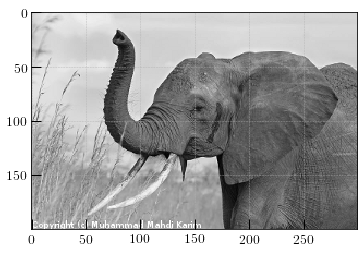

In [2]:
img_filename="elephant.png"
factor=0.01
sigma=10
n_points=30
bounds=500

img = plt.imread(img_filename)
img = io.imread(img_filename, as_grey=True)
plt.imshow(img, cmap="gray")
plt.show()

## Distribuição Gaussiana

A variável gauss contem os pontos da distribuição gaussiana dentro dos limites, "bounds" 

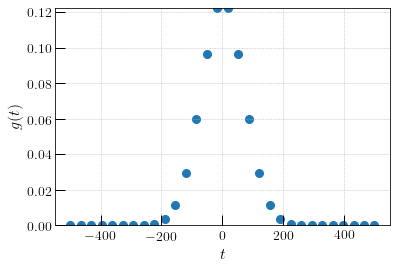

In [3]:
# First a 1-D  Gaussian
t = linspace(-bounds, bounds, n_points)
gauss = exp(-factor*(t)**2/sigma**2.)/(sqrt(2.*pi*sigma))

sum_gauss = "{:.2f}".format(np.trapz(gauss)) 
plt.scatter(t, gauss)
plt.ylabel(R"$g(t)$")
plt.xlabel(R"$t$")
plt.ylim(0, max(gauss))
plt.show()

Note que  a distribuição não está normalizada, tal que a soma é {{sum_gauss}} 

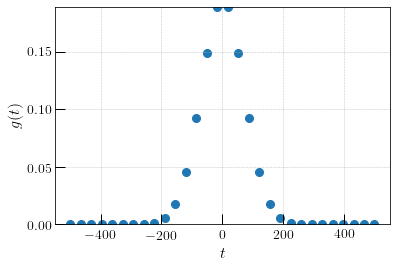

In [4]:
gauss /= np.trapz(gauss) 
sum_gauss = "{:.2f}".format(np.trapz(gauss)) 
plt.scatter(t, gauss)
plt.ylabel(R"$g(t)$")
plt.xlabel(R"$t$")
plt.ylim(0, max(gauss))
plt.show()

Normalizando a distirbuição através da integral númerica (trapésios)  temos que a soma é {{sum_gauss}}. Tendo a distribuição gaussiana pronta, $g(t)$, construímos agora o núcleo, $\mathbf k$, 


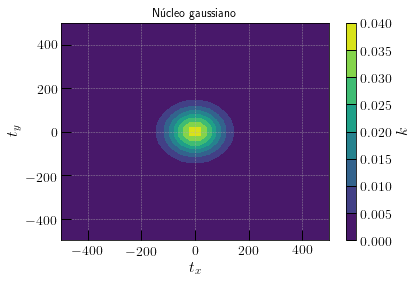

In [5]:
X, Y = np.meshgrid(t, t)
kernel = gauss[:, np.newaxis] * gauss[np.newaxis, :]
countour = plt.contourf(X, Y, kernel)
cbar = plt.colorbar(countour)
plt.xlabel(R"$t_x$")
plt.ylabel(R"$t_y$")
cbar.ax.set_ylabel(R"$k$")
plt.title("Núcleo gaussiano")
plt.show()

Agora aplicamos a transformada de fourrier no núcleo gaussiano tendo uma tamanho de janela igual a dimensão da imagem original

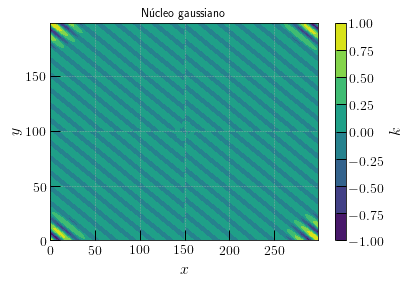

In [6]:

kernel_ft = fftpack.fft2(kernel, shape=img.shape, axes=(0, 1))


countour = plt.contourf( kernel_ft.real)
cbar = plt.colorbar(countour)
plt.xlabel(R"$x$")
plt.ylabel(R"$y$")
cbar.ax.set_ylabel(R"$k$")
plt.title("Núcleo gaussiano")
plt.show()

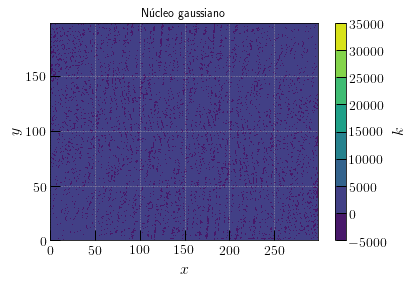

In [7]:

# convolve
img_ft = fftpack.fft2(img, axes=(0, 1))

countour = plt.contourf( img_ft.real)
cbar = plt.colorbar(countour)
plt.xlabel(R"$x$")
plt.ylabel(R"$y$")
cbar.ax.set_ylabel(R"$k$")
plt.title("Núcleo gaussiano")
plt.show()

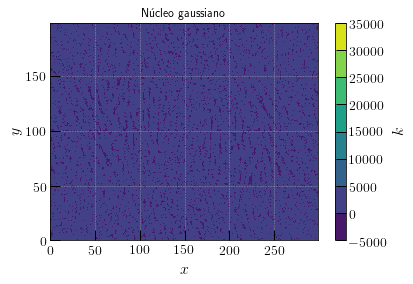

In [8]:
# convolve

img2_ft = kernel_ft[:, :] * img_ft

countour = plt.contourf( img2_ft.real)
cbar = plt.colorbar(countour)
plt.xlabel(R"$x$")
plt.ylabel(R"$y$")
cbar.ax.set_ylabel(R"$k$")
plt.title("Núcleo gaussiano")
plt.show()

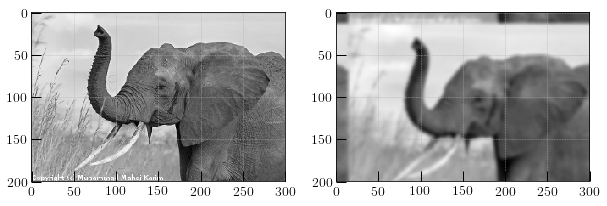

In [9]:


# the 'newaxis' is to match to color direction

#aplica a inversa da transformada
img2 = fftpack.ifft2(img2_ft, axes=(0, 1)).real

# clip values to range
#img2 = np.clip(img2, 0, 1)

# plot output
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(img2, cmap = "gray")
plt.show()

# Projeto II

## Descrição
## Objetivos

- Criar um fitlro gaussiano usando convolução e transformada de Fourrier

In [13]:
def apply_dof(
        img,
        ts,
        factor_1_x,
        factor_1_y,
        factor_2_x,
        factor_2_y,
        sigma_1_x,
        sigma_1_y,
        sigma_2_x,
        sigma_2_y,
        t0_1_x,
        t0_1_y,
        t0_2_x,
        t0_2_y,
    ):

    img_ft = fftpack.fft2(img, axes=(0, 1))
    
    gauss_1_x = exp(-factor_1_x*(ts-t0_1_x)**2/sigma_1_x**2.)/(sqrt(2.*pi*sigma_1_x**2.))
    gauss_1_y = exp(-factor_1_x*(ts-t0_1_y)**2/sigma_1_y**2.)/(sqrt(2.*pi*sigma_1_y**2.))

    gauss_2_x = exp(-factor_2_x*(ts-t0_2_x)**2/sigma_2_x**2.)/(sqrt(2.*pi*sigma_2_x**2.))
    gauss_2_y  = exp(-factor_2_y*(ts-t0_2_y )**2/sigma_2_y**2.)/(sqrt(2.*pi*sigma_2_y**2.))

    gauss_1_x /= np.trapz(gauss_1_x) 
    gauss_2_x /= np.trapz(gauss_2_x)
    gauss_1_y /= np.trapz(gauss_1_y) 
    gauss_2_y /= np.trapz(gauss_2_y) 
    #dof = gauss_1 - gauss_2

    
    
    kernel = gauss_1_y[:, np.newaxis] * gauss_1_x[np.newaxis, :]

    kernel_ft_1 = fftpack.fft2(kernel, shape=img.shape, axes=(0, 1))

    kernel = gauss_2_y[:, np.newaxis] * gauss_2_x[np.newaxis, :]

    kernel_ft_2 = fftpack.fft2(kernel, shape=img.shape, axes=(0, 1))

    kernel_ft = kernel_ft_2 - kernel_ft_1

    img2_ft = kernel_ft[:, :] * img_ft

    # the 'newaxis' is to match to color direction

    #aplica a inversa da transformada
    img2 = fftpack.ifft2(img2_ft, axes=(0, 1)).real
    #img2 = np.clip(img2, 0, 1)
    return img2, gauss_1_x, gauss_1_y, gauss_2_x, gauss_2_y

# Projeto III

## Descrição
## Objetivos

- Criar um fitlro gaussiano usando convolução e transformada de Fourrier

In [14]:
def dof_uniform(
    img_filename="home.png",
        factor=0.001,
        sigma_1=5,
        sigma_2=2,
        t0 = 0,
        n_points=30,
        bounds=500,
        n_neighs = 4
    ):

    img = io.imread(img_filename, as_grey=True)


    neighs =  [(1, 0), (-1, 0), (0, 1), (0, -1)]
    if n_neighs==8:
         neighs += [(1, 1), (-1, 1), (-1, -1), (1, -1)]
    
    ts = linspace(-bounds, bounds, n_points)
    img2, gauss_1_x, gauss_1_y, gauss_2_x, gauss_2_y = apply_dof(
        img,
        ts,
        factor,
        factor,
        factor,
        factor,
        sigma_1,
        sigma_1,
        sigma_2,
        sigma_2,
        t0,
        t0,
        t0,
        t0,
    )
    #img2 = (img2 > threshold).astype(np.int_)
    for i in range(img2.shape[0]):
        for j in range(img2.shape[1]):
            val = img2[i, j]
            vals_neigh = []
            for dx, dy in neighs:
                try:
                    vals_neigh.append(img2[i+dx, j+dy])
                except:
                    pass
            borda = any([val*n <0 for n in vals_neigh])
            img2[i, j] = 1 if borda else 0.
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    ax[0].scatter(ts, gauss_1_x)
    ax[0].scatter(ts, gauss_2_x)
    #plt.scatter(t, dof)

    ax[0].set_ylabel(R"$g(t)$")
    ax[0].set_xlabel(R"$t$")
    ax[1].imshow(img, cmap="gray")
    

    ax[2].imshow(img2, cmap="gray")
    plt.show()


In [15]:
#img_filename="elephant.png"



interactive_plot = interactive(
                                dof_uniform,
                                img_filename=glob.glob('*.png'),
                                factor=(0.001, .1, .001),
                                sigma_1=(0.1, 10.0, .1),
                                sigma_2=(0.1, 10.0, .1),
                                t0 = (0.0001, 2),
                                bounds=500,
                                n_neighs = [4, 8]
                                    
                              )
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot



interactive(children=(Dropdown(description='img_filename', index=2, options=('elephant.png', 'hellblazer.png',…

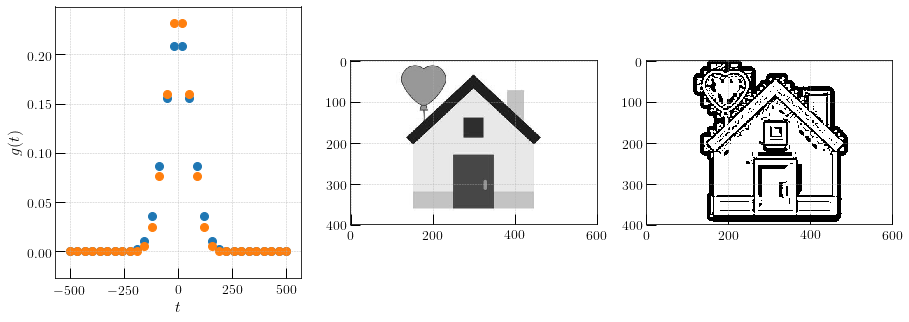

In [20]:
dof_uniform(
    img_filename="home.png",
        factor=0.01,
        sigma_1=9,
        sigma_2=8,
        t0 = 0,
        n_points=30,
        bounds=500,
        n_neighs = 8
    )

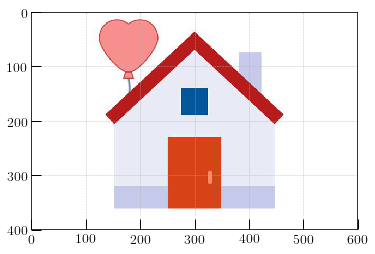

In [98]:
def dof_orientation(
    img_filename="elephant.png",
        factor_1=0.001,
        factor_2=0.001,
        sigma_1=5,
        sigma_2=2,
        t0_1 = 0,
        t0_2 = 0,
        n_points=30,
        bounds=500,
        threshold=.1
    ):

    img = io.imread(img_filename, as_grey=True)
    
    
    ts = linspace(-bounds, bounds, n_points)
    img2, gauss_1_x, gauss_1_y, gauss_2_x, gauss_2_y = apply_dof(
        img,
        ts,
        factor_1,
        factor_1,
        factor_2,
        factor_2,
        sigma_1,
        sigma_1,
        sigma_2,
        sigma_2,
        t0_1,
        t0_1,
        t0_2,
        t0_2,
    )


    img2 = (img2 > threshold).astype(np.int_)
    
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    ax[0].scatter(t, gauss_1_x)
    ax[0].scatter(t, gauss_2_x)
    #plt.scatter(t, dof)

    ax[0].set_ylabel(R"$g(t)$")
    ax[0].set_xlabel(R"$t$")
    ax[1].imshow(img, cmap="gray")
    

    ax[2].imshow(img2, cmap="gray")
    plt.show()